In [1]:

import Robogame as rg
import networkx as nx
import altair as alt
import time, json
import pandas as pd
import numpy as np

To start a game server go into the server directory. Make sure you have flask and networkx installed (```conda install networkx flask flask-cors requests scipy``` should do it).

To start a server do:

```python api.py [-d directoryforgame] [-s] [-t1s T1Secret] [-t2s T2Secret] gameid```

gameid is the the prefix of all the game files (the examples we gave you are examplematch1, examplematch2, examplematch3.

```
-d/--directory is an optional directory. For example, we put the examplematch1 files in the example1 directory
-s/--simulated tells us whether to simulate team 2
-t1s/--team1secret is Team 1's secret. If you don't specify this, the server will give you one
-t2s/--team1secret is Team 2's secret. This is ignored if you use -s. If you don't specify this, the server will give you one
-m/--matchsave is a log file to save the game in, a random log name will be used if you don't specify this
```

Here's a simple game:

```python api.py -d ./example1 -s -t1s bob examplematch1```

We're using the examplematch1 files in the example1 directory, simulating player 2 and team 1's secret is 'bob' (that's us)

In [ ]:
# create a game connection using bob as the "secret" key for your team (this is what you're given by the server)
# game = rg.Robogame("bob")

# the default is to the localhost on port 5000, if you want something else you can do:
game = rg.Robogame("bob",server="12.12.31.1",port=2324)

: 

In [9]:
# tell the server we're ready to go
game.setReady()

{'Result': 'OK'}

In [10]:
game.getGameTime()

{'Error': 'Game not started'}

In [42]:
# get the current game time
# there is a buffer before the game actually starts once both teams are ready

# wait for both players to be ready
while(True):
    gametime = game.getGameTime()
    timetogo = gametime['gamestarttime_secs'] - gametime['servertime_secs']
    
    if ('Error' in gametime):
        print("Error"+str(gametime))
        break
    if (timetogo <= 0):
        print("Let's go!")
        break
        
    print("waiting to launch... game will start in " + str(int(timetogo)))
    time.sleep(1) # sleep 1 second at a time, wait for the game to start
    

KeyError: 'gamestarttime_secs'

In [11]:
# check the current game time
game.getGameTime()

{'curtime': 2.24,
 'gameendtime_secs': 1638410887.7510457,
 'gamestarttime_secs': 1638410287.7510457,
 'servertime_secs': 1638410301.16193,
 'unitsleft': 97.76}

In [20]:
# get the robot data (note that the bets column are the guesses your team has associated with the robots at the moment)
robots = game.getRobotInfo()

# if you want this in json format, do:
# robots = game.getRobotInfo(js=True)
robots

,id,name,expires,winner,Productivity,bets
0,0,Waterpulverizer Boterson II,57.0,-2,NaN,50
1,1,Stonelift Botberg,60.0,-2,NaN,50
2,2,Stoneborer Botchik,50.0,2,78.317349,50
3,3,Pullwaller Botchik Jr.,40.0,2,42.332495,50
4,4,Excawalker Botchik,20.0,2,91.080533,50
...,...,...,...,...,...,...
147,147,Thumphauler Botson Jr.,NaN,-2,NaN,-1
148,148,Rockborer Botson,NaN,-2,NaN,-1
149,149,Pushdigger Botberg Jr.,NaN,-2,NaN,-1
150,150,Extraborer Botsky,NaN,-2,NaN,-1


In [19]:
# see what's inside
robots.sample(10)

,id,name,expires,winner,Productivity,bets
116,116,Pullpulverizer Botski II,NaN,-2,NaN,-1
37,37,Waterwidget Botson,21.0,-2,NaN,-1
21,21,Wallpulverizer Botsky II,68.0,-2,NaN,-1
106,106,Stoneminer Botchik II,NaN,-2,NaN,-1
144,144,Firewidget Botsky I,NaN,-2,NaN,-1
79,79,Excaborer Botchik I,21.0,-2,NaN,-1
119,119,Rockdigger Botberg,NaN,-2,NaN,-1
143,143,Pushwalker Botson,NaN,-2,NaN,-1
76,76,Extrawaller Boterson,76.0,-2,NaN,-1
64,64,Excahauler Botberg,25.0,-2,NaN,-1


In [20]:
# let's plot the distribution of expirations
alt.Chart(robots).mark_bar().encode(
    alt.X("expires:Q", bin=True),
    y='count()',
)

alt.Chart(...)

In [21]:
# grab the networks
network = game.getNetwork()

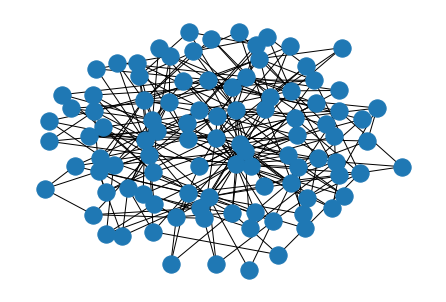

In [22]:
# use the networkx package to parse it and plot it
socialnet = nx.node_link_graph(network)
nx.draw_kamada_kawai(socialnet)

In [23]:
# get the genealogy tree
tree = game.getTree()

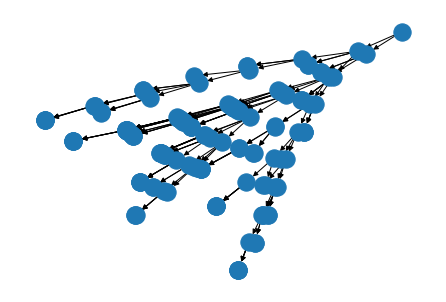

In [24]:
# use networkx to parse and plot it
genealogy = nx.tree_graph(tree)
nx.draw_kamada_kawai(genealogy)

In [6]:
game.getHints()

{'Error': 'Game completed'}

In [25]:
# we can get hints every 6 seconds or so, let's grab a few rounds of hints

# note that you can now do getHints(hintstart=4)  where the number indicates
# from when to give you the hints (so this will give you everything from time
# unit 4 until now)
for i in np.arange(0,3):
    # this will give us just the new hints, but the object will store everything we've seen
    hints = game.getHints()
    if ('parts' in hints):
        print('we got '+str(len(hints['parts']))+' part hints')
    time.sleep(6)


# get all the hints we've collected
predHints = game.getAllPredictionHints()
partHints = game.getAllPartHints()

we got 6 part hints
we got 12 part hints
we got 12 part hints


In [26]:
# make the time hints into a dataframe
predhints_df = pd.read_json(json.dumps(predHints),orient='records')

In [27]:
# lets plot the data we got from all the robots
alt.Chart(predhints_df).mark_point().encode(
    x='time:Q',
    y='mean(value):Q'
)

alt.Chart(...)

In [28]:
# we can tell the hacker we're interested in robots 99, 23 and 1
game.setRobotInterest([99,23,5])

# to reset to being interested in all, use
# game.setRobotInterest([])

{'Result': 'OK'}

In [29]:
# we can also tell the hacker we're interesed in the 'Astrogation Buffer Length','InfoCore Size'
game.setPartInterest(['Astrogation Buffer Length','InfoCore Size'])

# to reset to being interested in all, use
# game.setPartInterest([])

{'Result': 'OK'}

In [51]:
# if we get more hints now, they'll be biased to the robots and parts we care about

for i in np.arange(0,3):
    # this will give us just the new hints, but the object will store everything we've seen
    hints = game.getHints()
    if ('parts' in hints):
        print('we got '+str(len(hints['parts']))+' part hints')
    time.sleep(6)

we got 444 part hints
we got 12 part hints
we got 12 part hints


In [31]:
# to set our bets, feed in a dictionary with the values
# for example, let's set robot id 0 to 99 and robot 5 to 72
game.setBets({0:99,5:72})

{'Result': 'OK'}

In [32]:
# let's see how we're doing, grab the data
robots = game.getRobotInfo()

In [33]:
# let's see how team 2 is doing (might be 0 if no deadlines expired)
robots[robots.winner == 2]['Productivity'].sum()

0.0

In [34]:
# let's see how team 1 is doing (might be 0 if no deadlines expired or we didn't put in any bets)
robots[robots.winner == 1]['Productivity'].sum()

0.0

In [35]:
# Here's a hint on how you can use the data you get to predict the value.
# Let's say we learn two points about a robot's random number generator
# At time 17, they'll say 40 and at time 50, they'll say 27
xs = [17,50]
ys = [40,27]

In [36]:
# we can use this to generate simple regression. One way to do it is to just fit a one dimensional polynomial
fit = np.polyfit(xs,ys,1)

# in reality, 1 dimension is probably not ideal

In [37]:
# next, we'll want to figure out all the y values over the range of times 0 to 100
fitx = np.arange(0,100)
fity = []

In [38]:
# create the fit function using the fit we calculated above
fitfunc = np.poly1d(fit)
for x in fitx:
    y = fitfunc(x)
    if (y > 100): # we know y can't be > 100
        y = 100
    if (y < 0): # we know y can't be < 0
        y = 0
    fity.append(y)

In [39]:
# to visualize this, I'm going to build a dataset the has both the original numbers 
# our hacker gave us (17,50 and 40,27) and the new things we calculated:
vals = []
for i in np.arange(0,len(xs)):
    vals.append({'t':'hint','x':int(xs[i]),'y':int(ys[i])})
   
for i in np.arange(0,len(fitx)):
    vals.append({'t':'fit','x':int(fitx[i]),'y':int(fity[i])})

# so now we have a dataset with both the hint and fit data
# you can look at it here
# vals

In [40]:
# finally, let's plot the data using Altair

# first make a chart for the hints
hintlayer = alt.Chart(alt.Data(values=vals)).mark_circle(filled=True,size=90,color='red').encode(
    x='x:Q',
    y='y:Q',
    color='t:N'
).transform_filter(
    alt.datum.t == 'hint'
)

# overlay that with the predictions
fitlayer = alt.Chart(alt.Data(values=vals)).mark_line().encode(
    x='x:Q',
    y='y:Q',
    color='t:N'
).transform_filter(
    alt.datum.t == 'fit'
)

# and let's assume an expiration of 70 for this robot and draw a line on top

annotationlayer = alt.Chart(pd.DataFrame({'x': [70]})).mark_rule().encode(x='x:Q')

# layer the charts
hintlayer + fitlayer + annotationlayer


alt.LayerChart(...)

## A few other random "recipes"

In [41]:
# set all the bets to 80
bets = {}
for i in np.arange(0,100):
    bets[int(i)] = int(80)
game.setBets(bets)

{'Result': 'OK'}

In [7]:
# get all the game parts since the start of the game
game.getHints(hintstart=0)['parts']

[{'column': 'Astrogation Buffer Length', 'id': 41, 'value': 1.0},
 {'column': 'InfoCore Size', 'id': 21, 'value': 0.7283208449524946},
 {'column': 'InfoCore Size', 'id': 37, 'value': 0.4842304291840318},
 {'column': 'Arakyd Vocabulator Model', 'id': 81, 'value': 'model E'},
 {'column': 'Cranial Uplink Bandwidth',
  'id': 20,
  'value': -0.0486425487090307},
 {'column': 'Polarity Sinks', 'id': 5, 'value': 0.7530226411361209},
 {'column': 'InfoCore Size', 'id': 92, 'value': 0.0858166164951381},
 {'column': 'Astrogation Buffer Length', 'id': 28, 'value': 11.0},
 {'column': 'Polarity Sinks', 'id': 30, 'value': 0.582722135187538},
 {'column': 'InfoCore Size', 'id': 7, 'value': 0.0500750932850488},
 {'column': 'InfoCore Size', 'id': 23, 'value': 0.3530564278231974},
 {'column': 'Arakyd Vocabulator Model', 'id': 94, 'value': 'model C'},
 {'column': 'AutoTerrain Tread Count', 'id': 61, 'value': 1.1635594671542333},
 {'column': 'InfoCore Size', 'id': 24, 'value': -0.1201885018111612},
 {'column

In [43]:
# debug information while game is in simulation
game.getDebug()

{}

In [8]:
pd.DataFrame(game.getAllPartHints())

,column,id,value
0,Astrogation Buffer Length,41,1.0
1,InfoCore Size,21,0.728321
2,InfoCore Size,37,0.48423
3,Arakyd Vocabulator Model,81,model E
4,Cranial Uplink Bandwidth,20,-0.048643
...,...,...,...
277,Repulsorlift Motor HP,95,83.0
278,Sonoreceptors,44,0.546992
279,Cranial Uplink Bandwidth,79,0.623617
280,Cranial Uplink Bandwidth,55,0.890899
